## import

In [104]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision.models import VGG16_Weights
from tqdm import tqdm

## data

In [ ]:
LABEL_COLORS = np.array(
        [
            # 0=background
            (0, 0, 0),
            # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
            (128, 0, 0),
            (0, 128, 0),
            (128, 128, 0),
            (0, 0, 128),
            (128, 0, 128),
            # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
            (0, 128, 128),
            (128, 128, 128),
            (64, 0, 0),
            (192, 0, 0),
            (64, 128, 0),
            # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
            (192, 128, 0),
            (64, 0, 128),
            (192, 0, 128),
            (64, 128, 128),
            (192, 128, 128),
            # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
            (0, 64, 0),
            (128, 64, 0),
            (0, 192, 0),
            (128, 192, 0),
            (0, 64, 128),
        ]
    )

In [52]:
def decode_segmap(image, number_classes: int = 21) -> np.ndarray:
    r: np.ndarray = np.zeros_like(image).astype(np.uint8)
    g = r.copy()
    b = r.copy()

    for class_index in range(0, number_classes):
        idx = image == class_index
        r[idx] = LABEL_COLORS[class_index, 0]
        g[idx] = LABEL_COLORS[class_index, 1]
        b[idx] = LABEL_COLORS[class_index, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


In [116]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)


In [118]:
class VOCSegmentation(torch.utils.data.Dataset):
    def __init__(self, root, year="2012", transform=None):
        self.transform = transform
        self.year = year
        self.root = os.path.join(root, f"VOCdevkit/VOC{self.year}/")

        self.mask_path = os.path.join(self.root, "SegmentationClass")

        self.mask_files = glob(self.mask_path + "/*.png")

    def __len__(self):
        return len(self.mask_files)

    def __getitem__(self, idx: int):
        mask = Image.open(self.mask_files[idx])
        image = Image.open(
            self.mask_files[idx]
            .replace("png", "jpg")
            .replace("SegmentationClass", "JPEGImages")
        )

        image = np.array(image)

        mask = np.array(mask)
        mask = np.where(mask == 255, 0, mask)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']

        return image, mask


In [119]:
train_dataset = VOCSegmentation(
    "/data/",
    transform=preprocess,
)


In [120]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True,
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


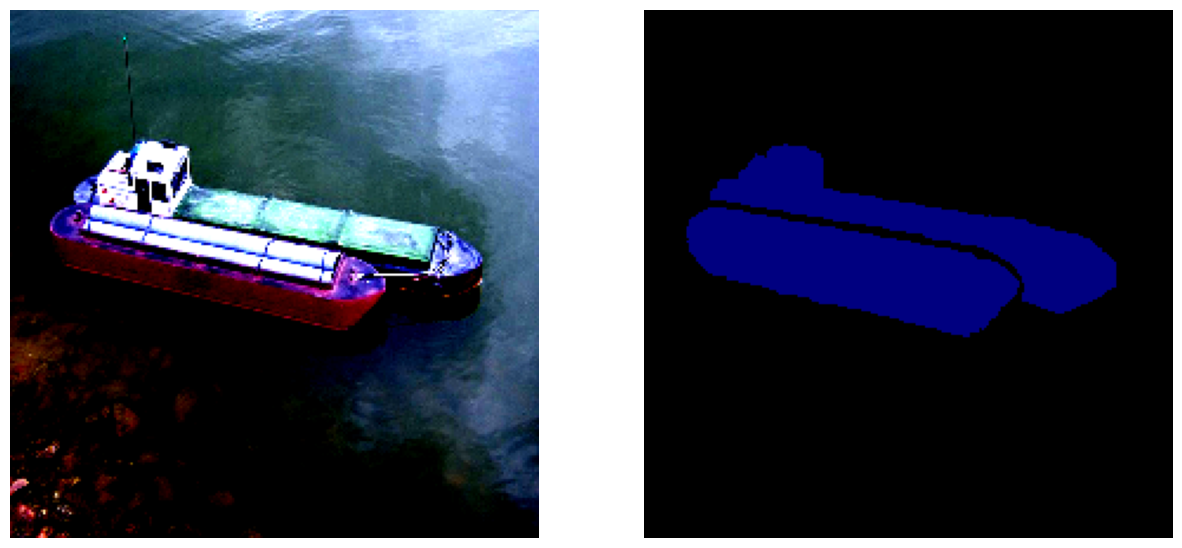

In [122]:
interest_pic = 102
img, label = train_dataset[interest_pic]
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img.permute(1, 2, 0).numpy())
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(decode_segmap(label))


## model

In [60]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.model = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

    def forward(self, x):
        maxpooling_map = []
        for i, layer in enumerate(self.model):
            x = layer(x)
            if isinstance(layer, nn.MaxPool2d):
                maxpooling_map.append(x)
        return maxpooling_map


In [61]:
class UpSampling(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpSampling, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        tmp = self.model(x)
        return tmp


In [62]:
class FCN(nn.Module):
    def __init__(self, n_classes):
        super(FCN, self).__init__()
        self.backbone = VGG()
        self.up1 = UpSampling(512, 512)
        self.up2 = UpSampling(512, 256)
        self.up3 = UpSampling(256, 128)
        self.up4 = UpSampling(128, 64)
        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, n_classes, 1),
        )

    def forward(self, x):
        feature_map = self.backbone(x)

        score = self.up1(feature_map[-1])
        score = score + feature_map[-2]
        score = self.up2(score)
        score = score + feature_map[-3]
        score = self.up3(score)
        score = score + feature_map[-4]
        score = self.up4(score)
        score = score + feature_map[-5]
        score = self.up5(score)
        return score


In [97]:
model = FCN(20 + 1).cuda()


In [64]:
# test forward
with torch.no_grad():
    model.eval()
    print(model(torch.randn(4, 3, 224, 224).cuda()).argmax(dim=1).unsqueeze(1).shape)


torch.Size([4, 1, 224, 224])


## training

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [66]:
EPOCHES = 15


In [ ]:
model.train()
for e in range(EPOCHES):
    running_loss = 0.0
    for data in tqdm(train_loader):
        img, label = data
        img = img.cuda()
        label = label.long().cuda()

        output = model(img).float()
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"epoch {e+1}: {running_loss/len(train_dataset)}")


## inference

In [125]:
test_preprocess = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)


In [126]:
test_dataset = VOCSegmentation(
    "/data/",
    transform=test_preprocess,
)


In [127]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=0,
)


In [ ]:
model.eval()
with torch.no_grad():
    dice = {class_idx: [] for class_idx in range(21)}
    for img, labels in tqdm(test_loader):
        img = img.cuda()

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        img = img.detach().cpu()

        for class_idx in range(21):
            coef = 2 * (output.eq(class_idx) * labels.eq(class_idx)).sum() / (1 + output.eq(class_idx).sum() + labels.eq(class_idx).sum())
            dice[class_idx].append(coef) 

for k, v in dice.items():
  dice[k] = np.mean(v)

In [ ]:
# show dice of each category
print(dict)

# show all
print(np.mean(list(dice.values())))

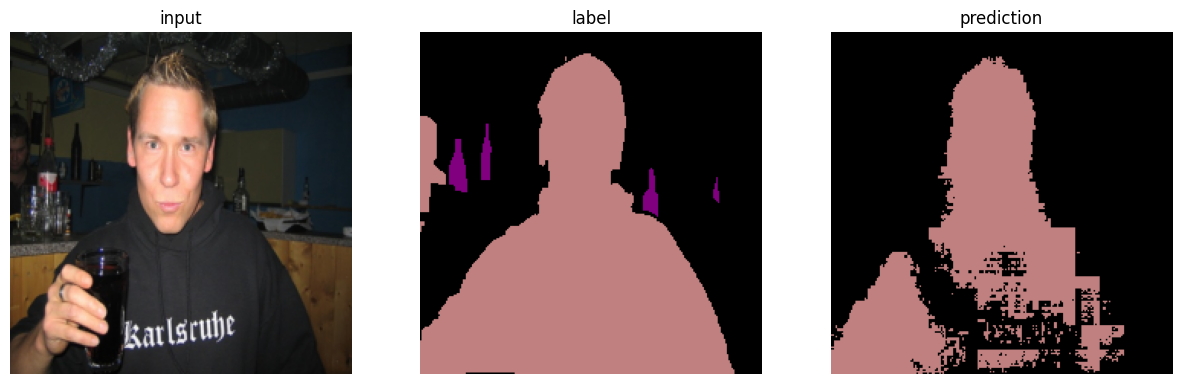

In [ ]:
interest_pic = 15

model.eval()
with torch.no_grad():
    target_img, target_label = train_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).cuda())
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title("input")
    plt.axis("off")
    plt.imshow(target_img.permute(1, 2, 0).numpy())
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.axis("off")
    plt.imshow(decode_segmap(target_label.numpy()))
    plt.subplot(1, 3, 3)
    plt.title("prediction")
    plt.axis("off")
    plt.imshow(decode_segmap(output.numpy()))


In [ ]:
# torch.onnx.export(model, torch.randn(1, 3, 224, 224).cuda(), "fcn.onnx")
